In [1]:
import random
import os
import glob



import cv2
import skimage
from skimage import transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

C:\Users\qin\AppData\Local\Continuum\anaconda3\envs\TF2.0\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
PATH = glob.glob('D:\\Data\\LiuRenYi\\ZengHuicode\\FFDM_Cut\\train\\*\\*resize.png')
data = pd.read_csv('data_info.csv',encoding='gb18030')



lr_dict = {'左':'L','右':'R'}

ID = []
for i in range(len(data['FS'])):
    ID.append(data.loc[i,'FS']+' '+lr_dict.get(data.loc[i,'L/R']))

label_dict = {'恶性':1,'良性':0}

label_dict = {ID[i]:label_dict.get(data.loc[i,'label']) for i in range(len(ID))} 


PATH[0].split('\\')[-2]

In [3]:
PATH[0].split('\\')[-2]

'rx001110 L'

In [4]:
data = pd.read_csv('data_info.csv',encoding='gb18030')

lr_dict = {'左':'L','右':'R'}

ID = []
for i in range(len(data['FS'])):
    ID.append(data.loc[i,'FS']+' '+lr_dict.get(data.loc[i,'L/R']))

label_dict = {'恶性':1,'良性':0}

label_dict = {ID[i]:label_dict.get(data.loc[i,'label']) for i in range(len(ID))} 

In [2]:
def load_dcm_and_label(path,label_dict):
    imagelist = []
    labellist = []
    for p in path:
        image = sitk.ReadImage(p)
        image = sitk.GetArrayFromImage(image)
        if image.shape != (1,3328,2560):
            image = transform.resize(image,(1,3328,2560))
        label = label_dict.get(p.split('\\')[-2])
        image = 2*(image-image.min())/(image.max()-image.min()) -1
        imagelist.append(image)
        labellist.append(label)
    imagelist = np.concatenate(imagelist)
    return imagelist , labellist

In [40]:
def image_augment(img,label):
    img = tf.expand_dims(img,2)
    img = tf.image.resize(img,(int(3328*0.7),int(2560*0.7)))
#     img = tf.image.random_flip_left_right(img)
#     img = tf.image.random_flip_up_down(img)
    return img,label

In [7]:
# data_image,data_label = load_dcm_and_label(PATH,label_dict)

In [8]:
# labelpd = pd.DataFrame({'label':data_label})
# labelpd.to_csv('dcm1_label.csv')

In [9]:
# np.save('dcm1_data.npy',data_image)

In [10]:
data_label = pd.read_csv('dcm1_label.csv',index_col=0)
data_label = data_label.values

In [11]:
data_image = np.load('dcm1_data.npy')

In [12]:
data_image.shape

(275, 3328, 2560)

In [41]:
dataset = tf.data.Dataset.from_tensor_slices((data_image,data_label))

In [42]:
dataset = dataset.map(image_augment)

In [43]:
image_num = data_image.shape[0]
train_num = int(image_num*0.8)
batch_size = 1


trainset = dataset.take(train_num)
testset = dataset.skip(train_num)

In [44]:
trainset = trainset.shuffle(train_num).batch(batch_size).repeat()

In [45]:
testset = testset.batch(batch_size).repeat()

In [46]:
IMG_SHAPE = (int(3328*0.7),int(2560*0.7), 1)
# Create the base model from the model 
base_model = keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None
                                           )

In [47]:
base_model.trainable = True

In [48]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs=base_model.inputs, outputs=predictions)

In [49]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=2e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
model_checkpoint = keras.callbacks.ModelCheckpoint('DeepBSI-restnet-gen02.hdf5', 
                                                   monitor='val_acc', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode="max")

In [51]:
epochs = 1000
steps_per_epoch = train_num // batch_size
validation_steps = (image_num-train_num)// batch_size

history = model.fit(trainset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
#                     workers=4,
                    validation_data=testset,
                    validation_steps=validation_steps,
                    callbacks = [model_checkpoint])

Train for 220 steps, validate for 55 steps
Epoch 1/1000
  2/220 [..............................] - ETA: 3:08:40 - loss: 0.7685 - accuracy: 0.5000WARNING:tensorflow:Can save best model only with val_acc available, skipping.


ResourceExhaustedError:  OOM when allocating tensor with shape[1,73,56,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/conv5_block3_out/Relu-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_139628]

Function call stack:
distributed_function


In [ ]:
model.summary()

Resize

In [2]:
PATH = glob.glob('D:\\Data\\LiuRenYi\\ZengHuicode\\FFDM_Cut\\train\\*\\*resize.png')
data = pd.read_csv('data_info.csv',encoding='gb18030')



lr_dict = {'左':'L','右':'R'}

ID = []
for i in range(len(data['FS'])):
    ID.append(data.loc[i,'FS']+' '+lr_dict.get(data.loc[i,'L/R']))

label_dict = {'恶性':1,'良性':0}

label_dict = {ID[i]:label_dict.get(data.loc[i,'label']) for i in range(len(ID))} 


PATH[0].split('\\')[-2]

'rx001110 L'

In [3]:
def load_label(PATH):
    LABEL = []
    for path in PATH:
        label = label_dict.get(path.split('\\')[-2])
        LABEL.append(label)
    return LABEL

In [4]:
def load_png_label(path,label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=3)
    img = img[:,300:1500]
    img = tf.image.resize(img,[1200,1200])
    img = tf.cast(img,tf.float32)
    img = img/255
    label = tf.reshape(label,[1])
    return img,label

In [5]:
Label = load_label(PATH)

In [6]:
train_set = tf.data.Dataset.from_tensor_slices((PATH,Label))

In [7]:
train_set = train_set.map(load_png_label)

In [8]:
train_set

<MapDataset shapes: ((1200, 1200, 3), (1,)), types: (tf.float32, tf.int32)>

(1200, 1200, 3)


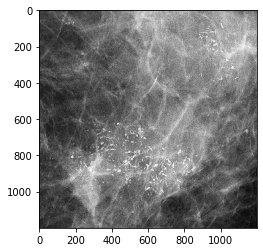

In [9]:
for i,j in train_set.take(1):
    print(i.shape)
    plt.figure()
    plt.imshow(i)
    plt.show()

In [10]:
batch_size = 2
train_set = train_set.shuffle(528).repeat().batch(batch_size)

In [11]:
train_set

<BatchDataset shapes: ((None, 1200, 1200, 3), (None, 1)), types: (tf.float32, tf.int32)>

In [12]:
val_PATH = glob.glob('D:\\Data\\LiuRenYi\\ZengHuicode\\FFDM_Cut\\val\\*\\*resize.png')
val_Label = load_label(val_PATH)
val_set =  tf.data.Dataset.from_tensor_slices((val_PATH,val_Label))
val_set = val_set.map(load_png_label)
val_set = val_set.repeat().batch(batch_size)

In [ ]:
IMG_SHAPE = (1200,1200, 3)
# Create the base model from the model 
base_model = keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet'
                                           )

base_model.trainable = True


x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
model = keras.Model(inputs=base_model.inputs, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_checkpoint = keras.callbacks.ModelCheckpoint('DeepBSI-restnet-gen02.hdf5', 
                                                   monitor='val_acc', 
                                                   verbose=1, 
                                                   save_best_only=True, 
                                                   mode="max")

epochs = 5000
train_num = len(PATH)
val_num = len(val_PATH)
steps_per_epoch = train_num // batch_size
validation_steps = val_num// batch_size

history = model.fit(train_set,
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
#                     workers=4,
                    validation_data= val_set,
                    validation_steps=validation_steps,
                    callbacks = [model_checkpoint])



Train for 264 steps, validate for 31 steps
Epoch 1/5000
264/264 [==============================] - 144s 545ms/step - loss: 0.7162 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5000
264/264 [==============================] - 130s 493ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5000
264/264 [==============================] - 130s 493ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5000
264/264 [==============================] - 135s 512ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5000
264/264 [==============================] - 133s 506ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.7046 - val_accuracy: 0.5000
Epoch 6/5000
264/264 [==============================] - 131s 497ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 1.6773 - val_accuracy: 0.5000
Epoch 7/5000
264/264 [==============================] - 131s 495ms/st

264/264 [==============================] - 131s 497ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 54/5000
264/264 [==============================] - 131s 497ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 55/5000
264/264 [==============================] - 131s 497ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 56/5000
264/264 [==============================] - 132s 499ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 57/5000
264/264 [==============================] - 131s 498ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 58/5000
264/264 [==============================] - 131s 496ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 59/5000
264/264 [==============================] - 131s 495ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0

Epoch 80/5000
264/264 [==============================] - 131s 495ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 81/5000
264/264 [==============================] - 131s 496ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 82/5000
264/264 [==============================] - 131s 495ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 83/5000
264/264 [==============================] - 131s 494ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 84/5000
264/264 [==============================] - 130s 494ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 85/5000
264/264 [==============================] - 131s 495ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 86/5000
264/264 [==============================] - 131s 495ms/step - loss: 0.6931 - accuracy: 0.5000